In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers_df = pd.read_csv("D:\\Assignment\\Customers.csv")
transactions_df = pd.read_csv("D:\\Assignment\\Transactions.csv")


customers_df["SignupDate"] = pd.to_datetime(customers_df["SignupDate"])
transactions_df["TransactionDate"] = pd.to_datetime(transactions_df["TransactionDate"])

# Aggregation of transaction data per customer
customer_transaction_agg = transactions_df.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    total_transactions=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean"),
    first_purchase=("TransactionDate", "min"),
    last_purchase=("TransactionDate", "max"),
).reset_index()


merged_df = pd.merge(customers_df, customer_transaction_agg, on="CustomerID", how="left")

# Missing values
merged_df.fillna({"total_spent": 0, "total_transactions": 0, "avg_transaction_value": 0}, inplace=True)
merged_df["first_purchase"].fillna(merged_df["SignupDate"], inplace=True)
merged_df["last_purchase"].fillna(merged_df["SignupDate"], inplace=True)

# Encoding 'Region' - categorical variable
if merged_df["Region"].isnull().sum() > 0:
    merged_df["Region"].fillna("Unknown", inplace=True)
label_encoder = LabelEncoder()
merged_df["Region"] = label_encoder.fit_transform(merged_df["Region"])

# Recency 
latest_date = merged_df["last_purchase"].max()
if pd.isna(latest_date):
    latest_date = pd.Timestamp.today()
merged_df["recency"] = (latest_date - merged_df["last_purchase"]).dt.days

# Features for clustering
features = ["Region", "total_spent", "total_transactions", "avg_transaction_value", "recency"]
clustering_data = merged_df[features]

# Normalization
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)



C:\Users\Nithin Sachin\AppData\Local\Temp\ipykernel_4612\159441018.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["first_purchase"].fillna(merged_df["SignupDate"], inplace=True)
C:\Users\Nithin Sachin\AppData\Local\Temp\ipykernel_4612\159441018.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

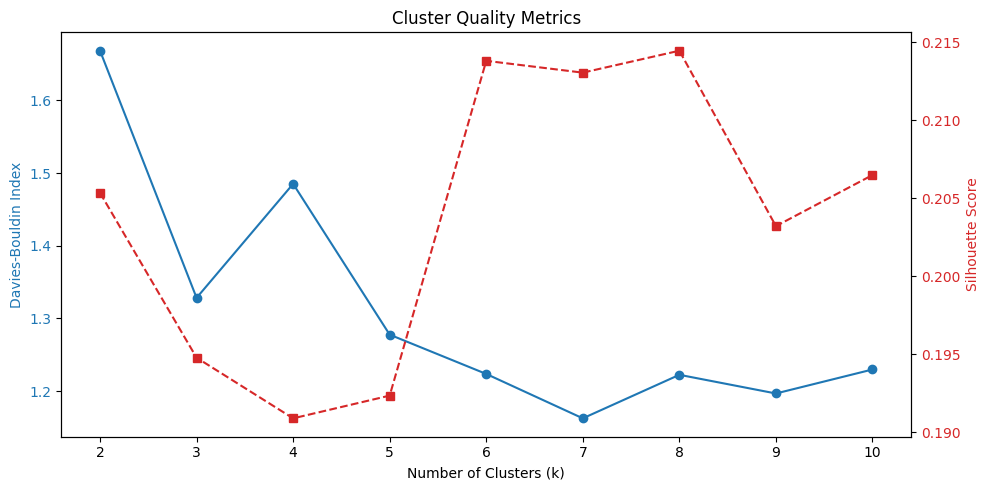

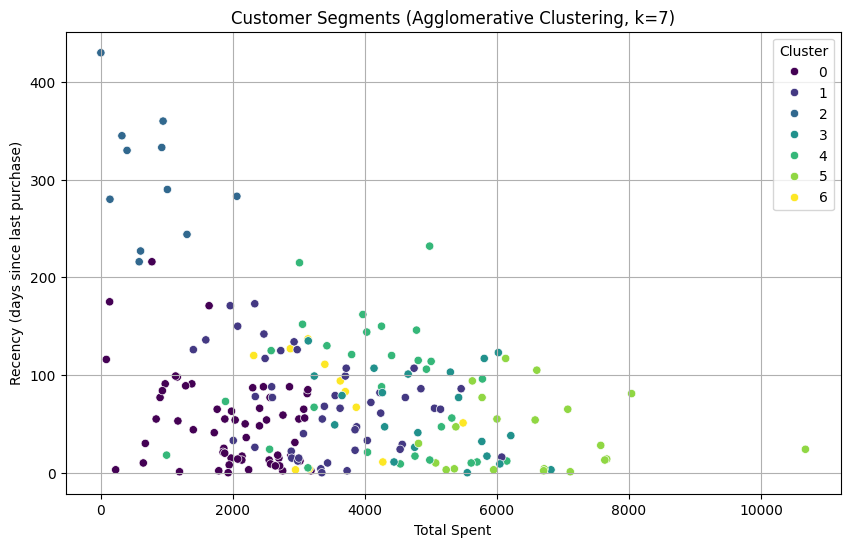

Optimal Number of Clusters: 7
Best Davies-Bouldin Index: 1.1624
Best Silhouette Score: 0.2130


,CustomerID,Region,total_spent,recency,Cluster
0,C0001,3,3354.52,55,1
1,C0002,0,1862.74,25,0
2,C0003,3,2725.38,125,1
3,C0004,3,5354.88,4,5
4,C0005,0,2034.24,54,0
5,C0006,3,4227.57,82,1
6,C0007,0,2579.82,125,4
7,C0008,2,4271.61,11,6
8,C0009,1,896.50,77,0
9,C0010,1,1717.55,41,0


In [19]:
# Optimal number of clusters
best_k = None
best_db_index = float("inf")
best_silhouette = float("-inf")
db_scores = []
silhouette_scores = []
k_values = list(range(2, 11))

for k in k_values:
    clustering_model = AgglomerativeClustering(n_clusters=k)
    clusters = clustering_model.fit_predict(clustering_data_scaled)
    db_index = davies_bouldin_score(clustering_data_scaled, clusters)
    try:
        silhouette_avg = silhouette_score(clustering_data_scaled, clusters)
    except ValueError:
        silhouette_avg = -1
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)
    if db_index < best_db_index:
        best_db_index = db_index
        best_k = k
        best_silhouette = silhouette_avg

# Agglomerative Clustering
final_clustering = AgglomerativeClustering(n_clusters=best_k)
merged_df["Cluster"] = final_clustering.fit_predict(clustering_data_scaled)

# DB Index & Silhouette Score
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Davies-Bouldin Index", color="tab:blue")
ax1.plot(k_values, db_scores, marker="o", linestyle="-", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax2 = ax1.twinx()
ax2.set_ylabel("Silhouette Score", color="tab:red")
ax2.plot(k_values, silhouette_scores, marker="s", linestyle="--", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
plt.title("Cluster Quality Metrics")
fig.tight_layout()
plt.show()

# Clusters Visualization 
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_df["total_spent"], y=merged_df["recency"], hue=merged_df["Cluster"], palette="viridis")
plt.title(f"Customer Segments (Agglomerative Clustering, k={best_k})")
plt.xlabel("Total Spent")
plt.ylabel("Recency (days since last purchase)")
plt.legend(title="Cluster")
plt.grid()
plt.show()

# Results
print(f"Optimal Number of Clusters: {best_k}")
print(f"Best Davies-Bouldin Index: {best_db_index:.4f}")
print(f"Best Silhouette Score: {best_silhouette:.4f}")

# Sample clustered data
merged_df[["CustomerID", "Region", "total_spent", "recency", "Cluster"]].head(10)